In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from glob import glob

import pathlib
import sys

path = pathlib.Path().resolve().parent
sys.path.insert(0, str(path))

from src.mixture_fit import fits, sum_exp, right_order, fits_baes
from src.data_loading import load_data
from src.bootstrapping import bootstrap
from src.main import data_analysis, data_analysis_baes

from typing import Optional

import warnings
warnings.filterwarnings("ignore")

In [6]:
def c_picker(val: float,
             lim1: float = 0.1,
             lim2: float = 0.3) -> str:
    """
    Color coding of the values

    Parameters
    ----------
    val: float
        Value to color code.
    lim1: float
        Limit value for green color.
    lim2: float
        Limit value for orange color.

    Returns
    -------
    str
        Color of the passed value.    
    """
    if val < lim1:
        return 'green'
    elif val < lim2:
        return 'orange'
    else:
        return 'red'
    

def calc_diff(results: np.ndarray,
              sigmas: np.ndarray,
              true_results: np.ndarray) -> np.ndarray:
    """
    Calculation of the mean difference between estimated
    and expected parameters in units of standart deviations.

    Parameters
    ----------
    results: np.ndarray
        Estimated results of the parameters.
    sigmas: np.ndarray
        Standard deviation values for the estimated parameteres.
    true_results: np.ndarray
        Expected results of the parameters.

    Returns
    -------
    diff: np.ndarray
        Mean difference between estimated and expected parameters
        in units of standart deviations. 
    """
    n = len(results)
    diff = np.zeros(n)
    for i in range(n):
        res = results[i]
        res_s = sigmas[i]
        tru_res = true_results[i]
        if len(res) < 4:
            diff[i] = 1
        else:
            for j in range(4):
                if np.abs(res[j] - tru_res[j]) > res_s[j]:
                    diff[i] += np.abs(res[j] - tru_res[j])/res[j]
                diff[i] = diff[i]/4
    return diff

In [7]:
def resolution(fun_name: str,
               bs_num: int = 100,
               size: int = 20,
               log: bool = True,
               save_path: Optional[str] = None,
               *args, **kwargs):
    """
    Testing procedure for resolution power
    of the chosen estimator.

    Parameters
    ----------
    fun_name: str
        The estimator to be used in the testing procedure.
        'WLS' for Weighted least squares,
        'MAP' for Maximum a posteriori estimator.
    bs_num: int = 100
        Number of simulations to run for each point on the parameter space.
    size: int = 20
        Number of points to divide the parameter space into along each axis.
    log: bool = True
        If True prints/draws the output.
    save_path: str or None = None
        Path to save the plot if log=True. If None draws the plot
        in interactive window.
    *args, **kwargs
        Used to pass arguments to fun. Avoid repetitions with resolution arguments.

    Returns
    -------
    w_space: np.ndarray
        Array with the values of weights of the first component used in testing
    D_space: np.ndarray
        Array with the values of self-diffusion coefficient of the first component
        used in testing.
    guess_arr: np.ndarray
        2-d array with the number of correctly guessed number of components across
        the parameter space.
    mean_arr: np.ndarray
        3-d array with the mean values of parameters among the correctly guessed components
        across the parameter space.
    std_arr: np.ndarray
        3-d array with the std values of parameters among the correctly guessed components
        across the parameter space.
    results: np.ndarray
        Results of estimating the parameters on real data with the chosen estimator.
    true_result: np.ndarray
        Expected parameters on the real data.
    """
    if fun_name == 'WLS':
        fun = fits
    elif fun_name == 'MAP':
        fun = fits_baes
    else:
        raise ValueError('fun_name must be "WLS" or "MAP".')
    # Calculate the parameter space of given size.
    w_space = np.linspace(0, 0.5, size)
    D_space = np.linspace(0.1, 1, size)

    folder = pathlib.Path(path,'data', 'R2_5times')
    data_path = pathlib.Path(folder, f'DOSY-R2-1-4-DMSO-128points-1.txt')
    x, _ = load_data(data_path)
    guess_arr = np.zeros((len(w_space), len(D_space)))
    mean_arr = np.zeros((len(w_space), len(D_space), 4))
    std_arr = np.zeros((len(w_space), len(D_space), 4))
    with tqdm(total=len(w_space) * len(D_space), desc='Calculating parameter space') as pbar:
        for w_idx, w1 in enumerate(w_space):
            for D_idx, D1 in enumerate(D_space):
                w2, D2 = 1 - w1, 1
                params = np.array([w1, D1, w2, D2])
                y_model = sum_exp(params, x)
                res, optim_res = bootstrap(fun, x, y_model, 0.0186, num=bs_num, show_progress=False, *args, **kwargs)

                correct_guess = (optim_res[:, 0] == 1)
                if correct_guess.sum() == 0:
                    correct_mean = np.zeros(4)
                    correct_std = np.zeros(4)
                else:
                    stacked_res = np.vstack(optim_res[:, 1][correct_guess])
                    correct_mean = stacked_res.mean(0)
                    correct_std = stacked_res.std(0)

                guess_arr[w_idx, D_idx] = correct_guess.sum()
                mean_arr[w_idx, D_idx] = correct_mean
                std_arr[w_idx, D_idx] = correct_std

                pbar.update(1)
    
    # Calculate the parameteres of real data with chosen optimization method.
    files = glob(f'{path}/data/R?-R?/R?-R?-?-?*.txt')
    D_coef_dict = {'R1':0.27, 'R2':1.044, 'R4':0.70, 'R5':0.46}

    label, results = [], []
    results_std = []
    for file in tqdm(files, desc='Calculating real data optimization parameteres'):
        x, y = load_data(file)
        try:
            if fun_name == 'WLS':
                indx, params_opt, params_opt_std = data_analysis(x, y)
            elif fun_name == 'MAP':
                indx, params_opt, params_opt_std = data_analysis_baes(x, y)

            label.append(file[11:file.find('.txt')])
            results.append(params_opt)
            results_std.append(params_opt_std)
        except ValueError:
            label.append(file[11:file.find('.txt')])
            results.append(np.zeros(4))
            
    # Calculate the expected values of real data
    true_result = []
    for file in files:
        parser = file[file.find('.txt')-9:file.find('.txt')].split('-')
        total_portions = int(parser[2]) + int(parser[3])
        out_params = [int(parser[2])/total_portions, D_coef_dict[parser[0]], int(parser[3])/total_portions, D_coef_dict[parser[1]]]
        out_params = right_order(np.array(out_params))
        true_result.append(out_params)
    true_result = np.vstack(true_result)

    if log:
        D_axis = D_space-np.diff(D_space)[0]/2
        w_axis = 1 - 2 * (w_space)
        w_axis = w_axis - np.diff(w_axis)[0]/2

        plt.close('all')
        plt.figure(figsize=(8,8))

        abs_diff = calc_diff(results, true_result, results_std) #(np.abs(results - true_result)/results).mean(1)
        colors = [c_picker(abs_diff_el, 0.05, 0.32) for abs_diff_el in abs_diff]
        
        ratio = []
        diff = []
        for res in results:
            if len(res) == 4:
                ratio.append(res[1]/res[3])
                diff.append(np.abs(res[2] - res[0]))
            else:
                ratio.append(1)
                diff.append(0)

        plt.pcolormesh(D_axis, w_axis, guess_arr/guess_arr.max(), vmin=0, vmax=1)
        plt.scatter(ratio, diff, edgecolors='black', c=colors)
        plt.xlabel('D1/D2 ratio')
        plt.ylabel('w2-w1')
        plt.colorbar(orientation='horizontal')
        plt.xticks(rotation=45)
        plt.xlim(left=D_axis.min())
        plt.ylim(bottom=w_axis.min())

        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, dpi=150)
        else:
            plt.show()

        print('Area')
        area = (guess_arr > 0.9).mean()
        print(area)

    return w_space, D_space, guess_arr, mean_arr, std_arr, results, true_result

Calculating parameter space:   0%|          | 0/16 [00:00<?, ?it/s]

Calculating real data optimization parameteres:   0%|          | 0/26 [00:00<?, ?it/s]

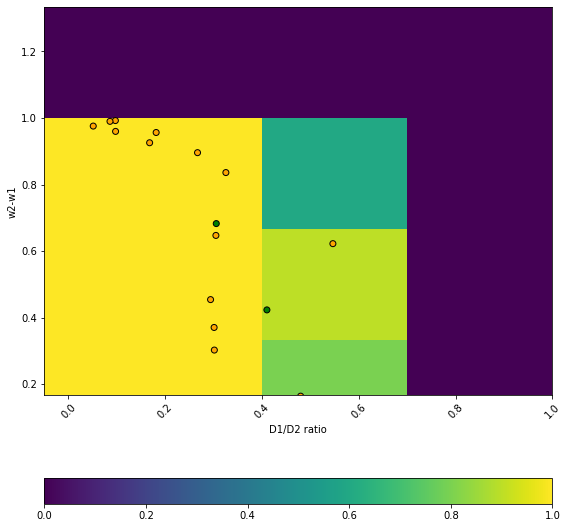

Area
0.5625


In [8]:
w_space, D_space, guess_arr, mean_arr, std_arr, results, true_result = resolution('WLS', bs_num=10, size=20,
                                                                                  method='BFGS', boost=True, reg=1.3, sigma=0.02)